In [1]:
import numpy as np
import matplotlib.pyplot as plt

import IAE_JAX

# Load data

In [2]:
data = np.load('data/spectra_sync.npz')

# Anchor points
AnchorPoints = data['anchr']

# Training, validation and test sets
XTrain = data['train']
XValidation = data['valid']
XTest = data['test']

t_length = np.shape(XTrain)[1]

del data

Learning stage - loss = 0.0017201, loss rel. var. = 0.0120962 : 100%|██████████| 10000/10000 [04:10<00:00, 39.87it/s]  
Learning stage - loss = 0.00134741, loss rel. var. = 0.0516294 : 100%|██████████| 10000/10000 [05:27<00:00, 30.54it/s] 
Learning stage - loss = 0.00107034, loss rel. var. = 7.2106e-05 : 100%|██████████| 10000/10000 [05:43<00:00, 29.15it/s]


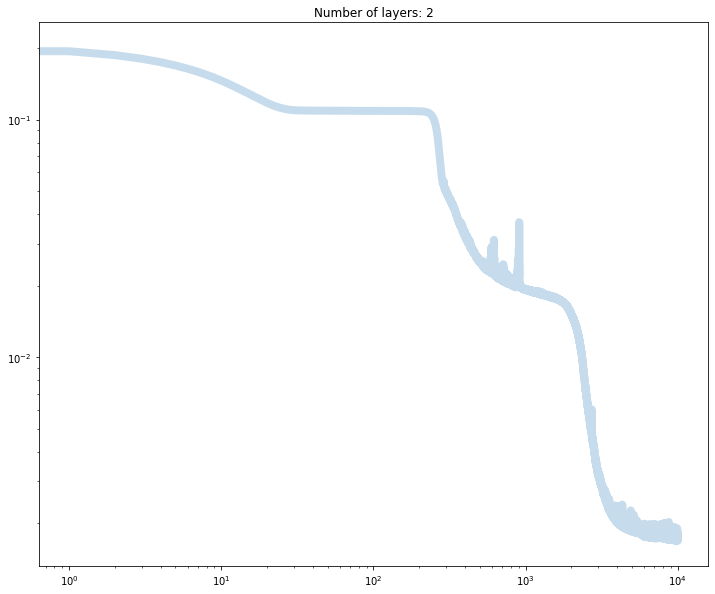

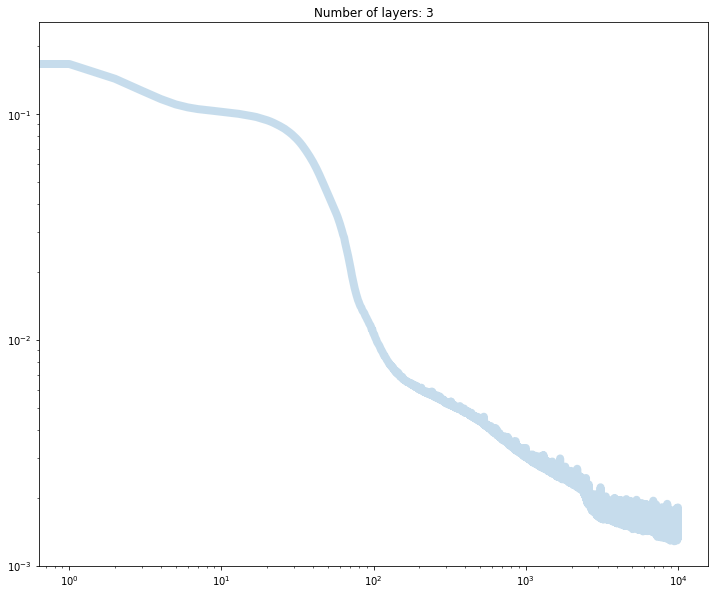

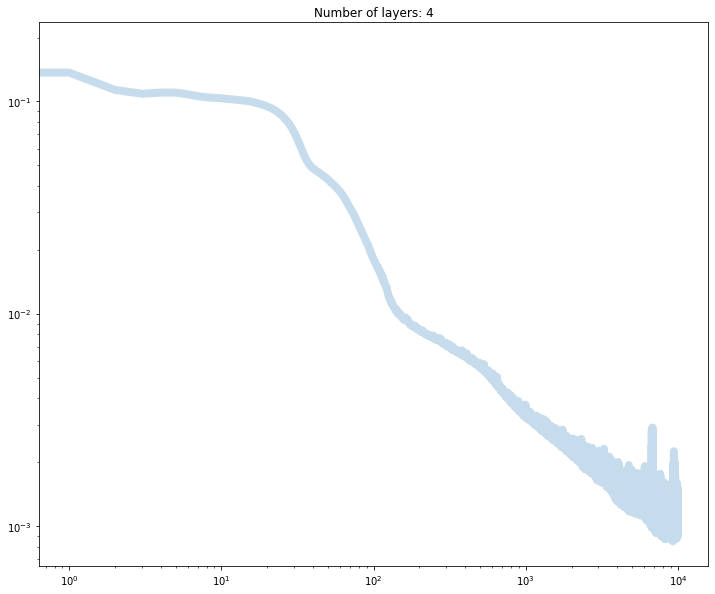

In [3]:
reg_parameter = 0.1
step_size = 1e-4
niter = 10000

vNL = [2,3,4]

fname = "model_sync"

for NL in vNL:  # layer-wise training
    if NL == 2:
        Model = None
    else:
        Model = IAE_JAX.load_model(fname)
    NSize = t_length * np.ones(NL+1,dtype='int')
    IAE = IAE_JAX.IAE(fname=fname, Model=Model, AnchorPoints=AnchorPoints, NSize=NSize, 
                      reg_parameter=reg_parameter, step_size=step_size, niter=niter, verb=True)
    _, outval = IAE.learning_stage(XTrain, XValidation=XValidation, batch_size=100)
    plt.figure(figsize=[12,10])
    plt.loglog(outval["total_cost"], lw=8, alpha=0.25)
    plt.title('Number of layers: %i' % NL)

# Model testing

In [4]:
# Load the model
noise_level = 0
Y = XTest + noise_level * np.random.randn(*np.shape(XTest))

Model = IAE_JAX.load_model(fname)
IAE= IAE_JAX.IAE(Model=Model)

In [5]:
# Fast interpolation
res_FI = IAE.fast_interpolation(Y)

In [6]:
# Barycentric span projection

niter = 1000 
step_size = 0.1 

res_BSP = IAE.barycentric_span_projection(Y, step_size=step_size, niter=niter)

Projection - loss = 6.19771e-05, loss rel. var. = 6.83207e-05:  15%|█▍        | 148/1000 [00:02<00:13, 64.66it/s]

Finished in 148 it. - loss = 6.19521e-05, loss rel. var. = 0 


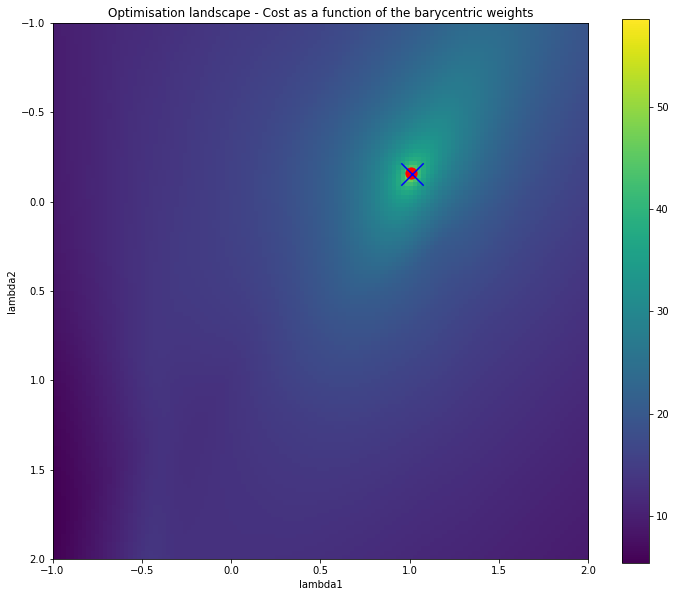

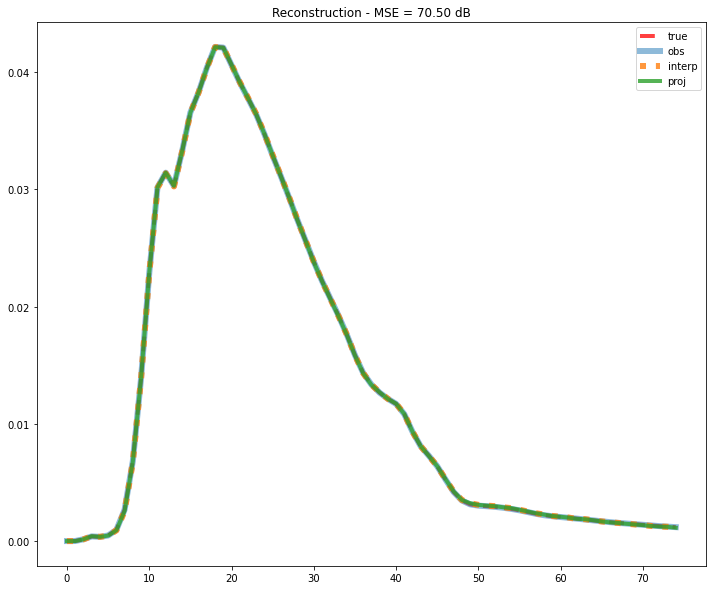

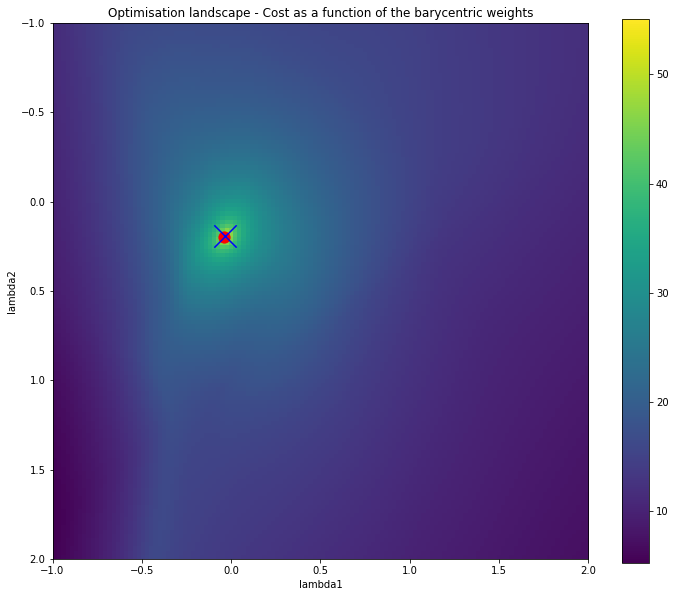

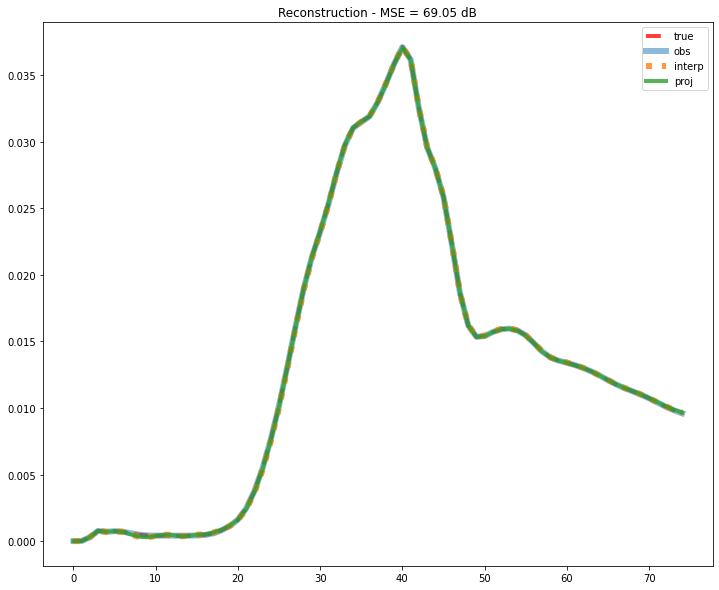

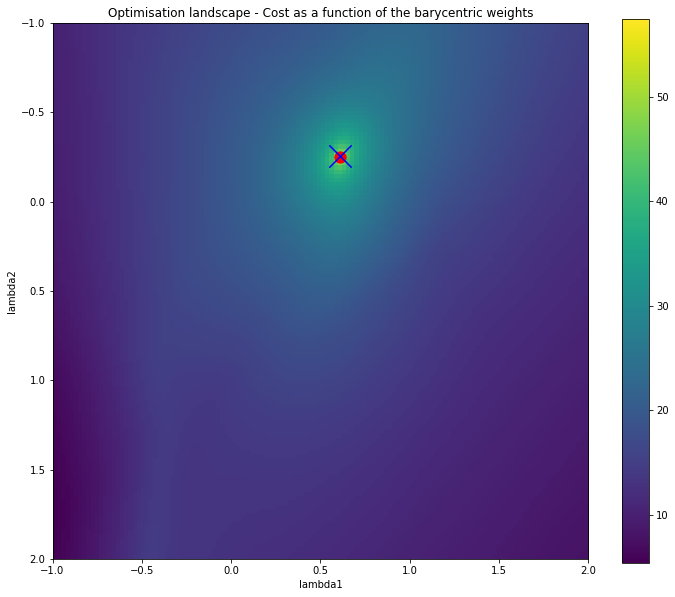

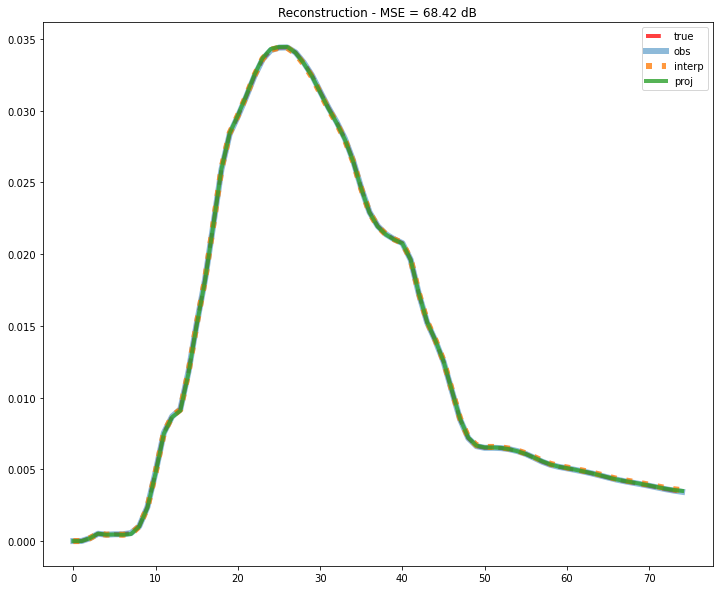

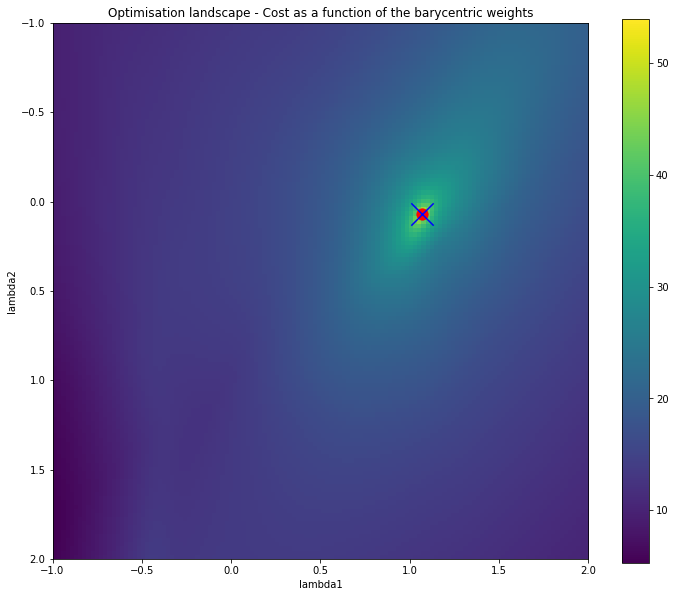

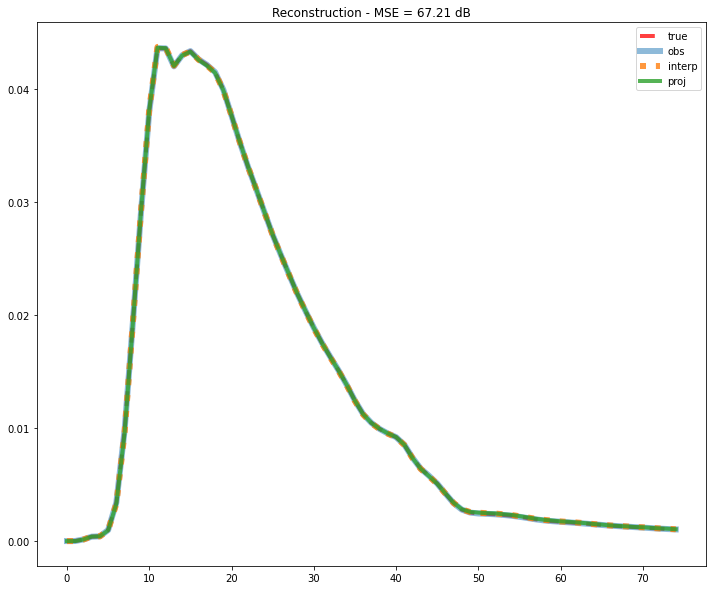

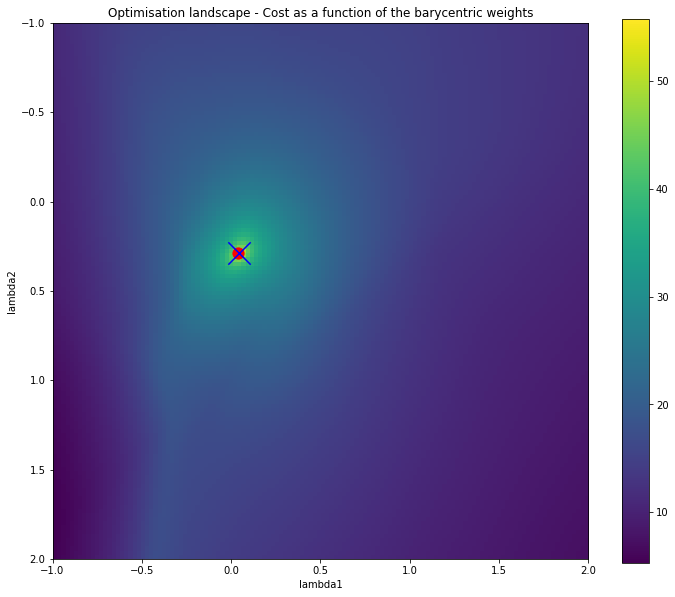

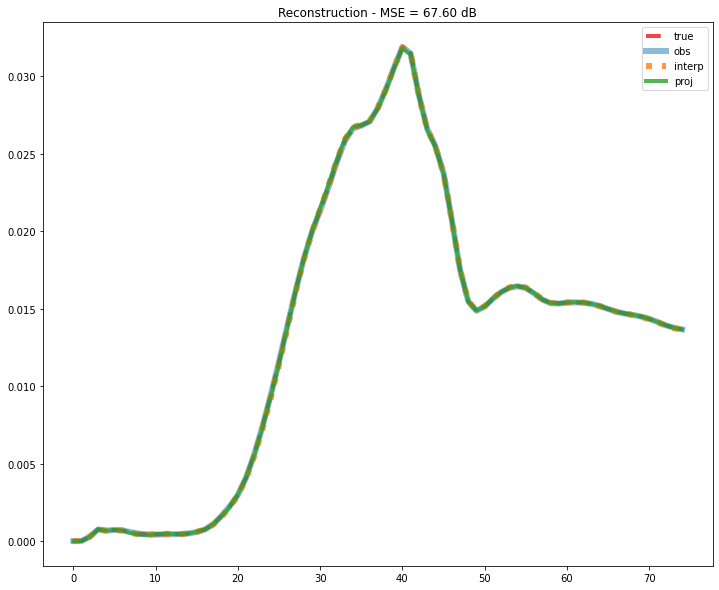

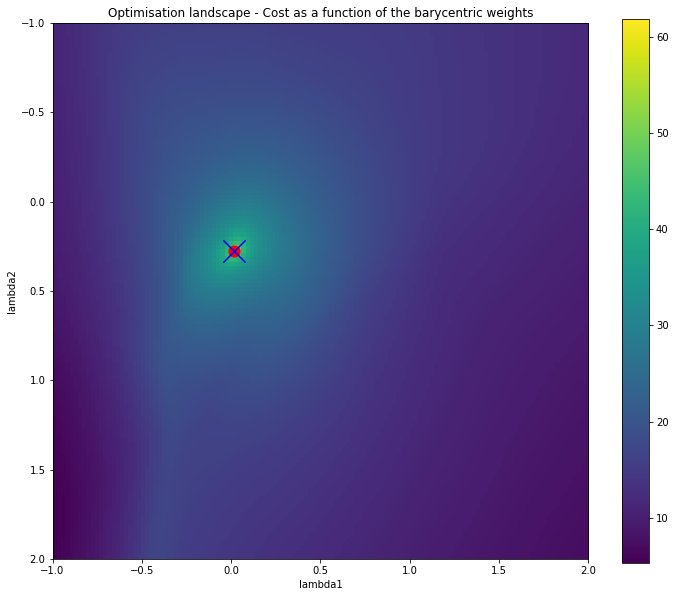

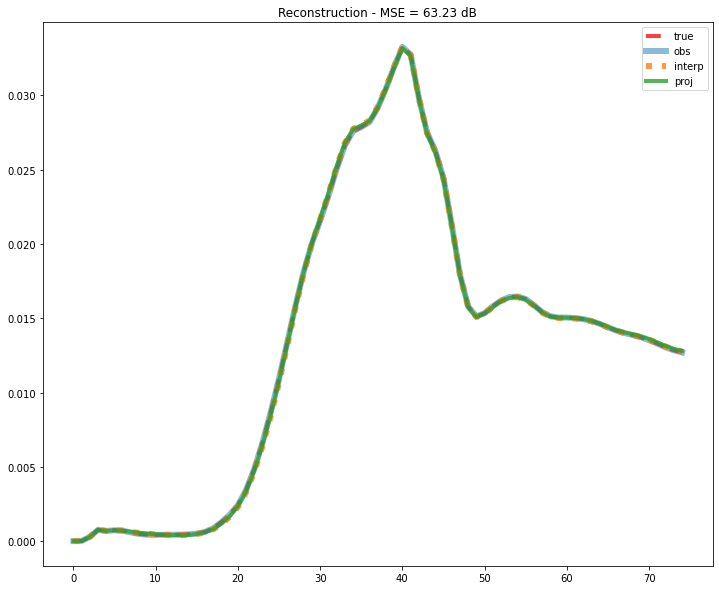

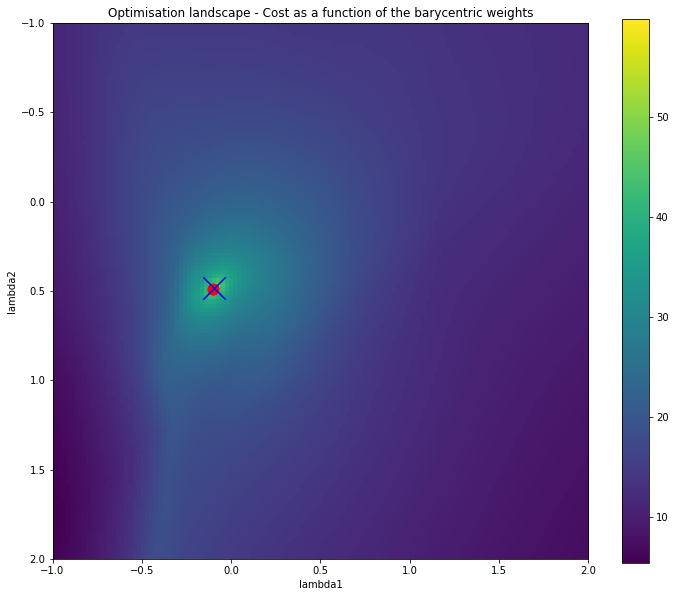

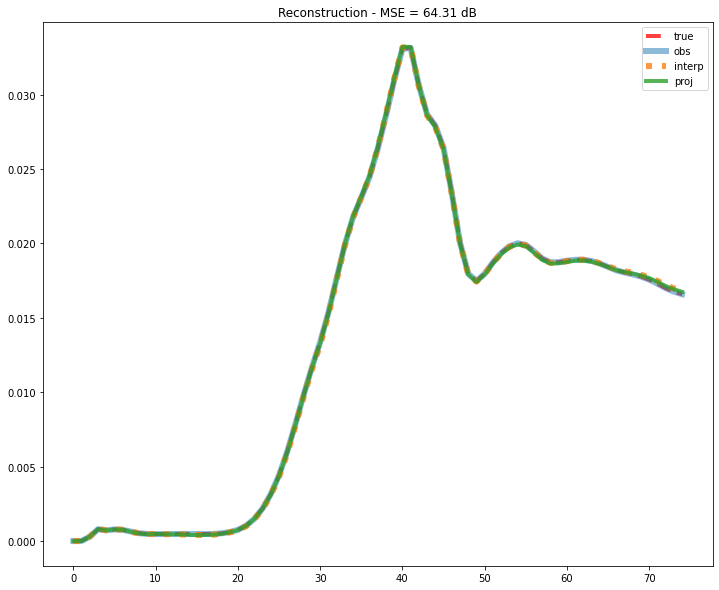

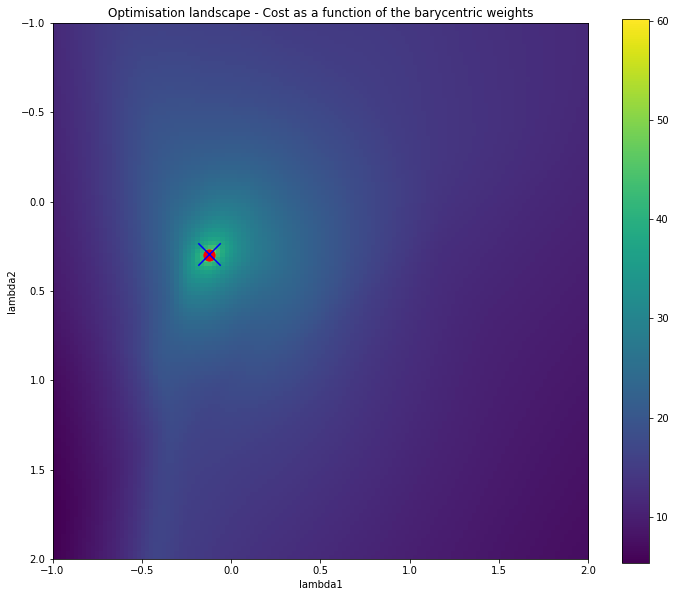

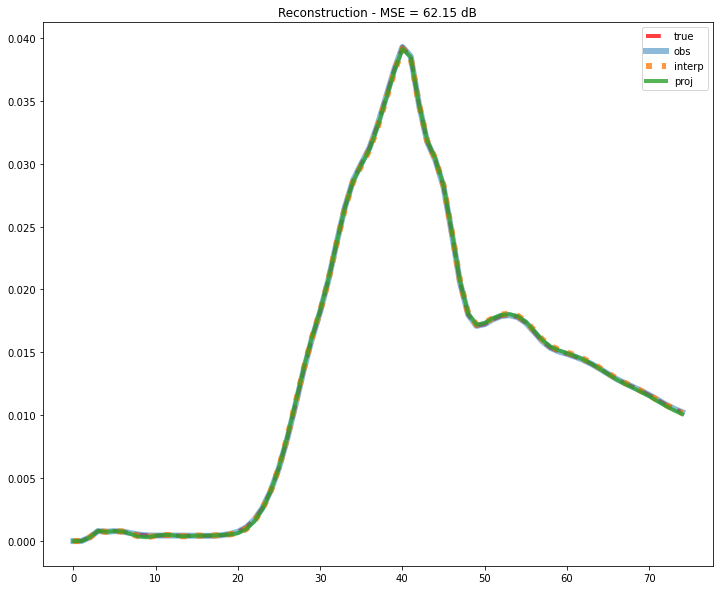

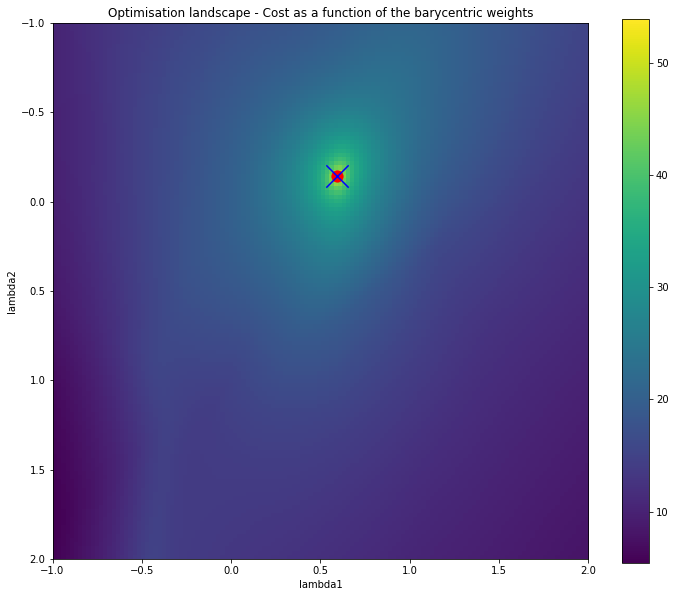

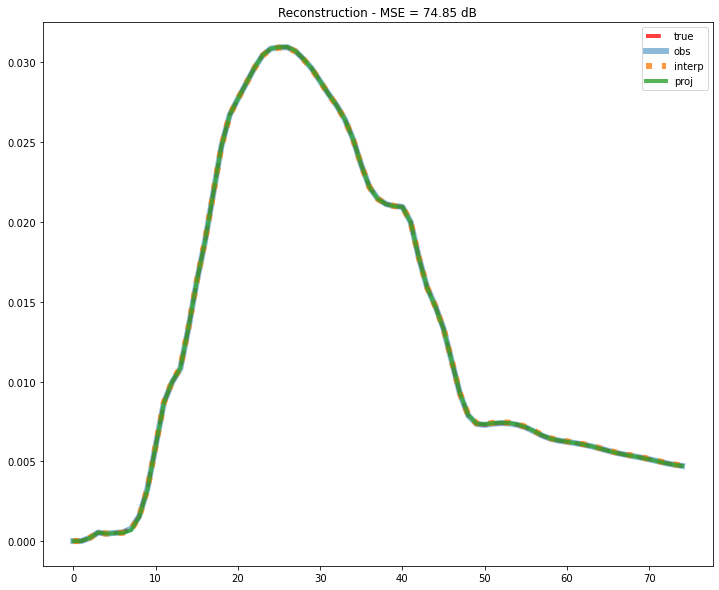

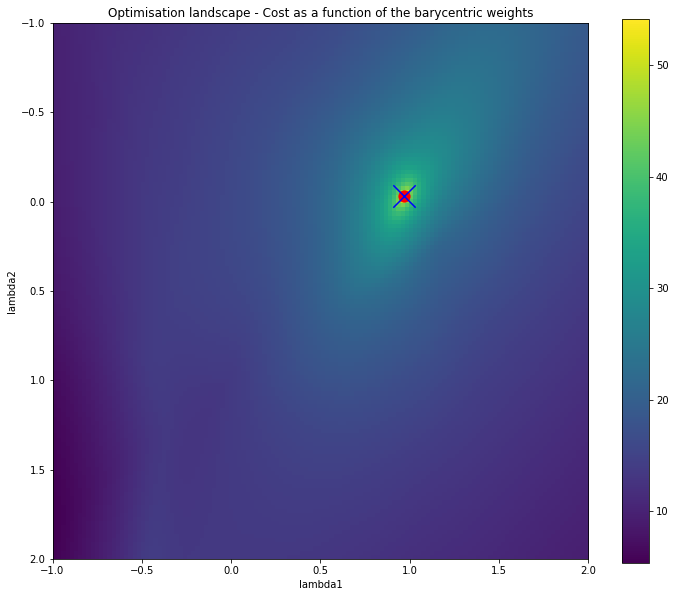

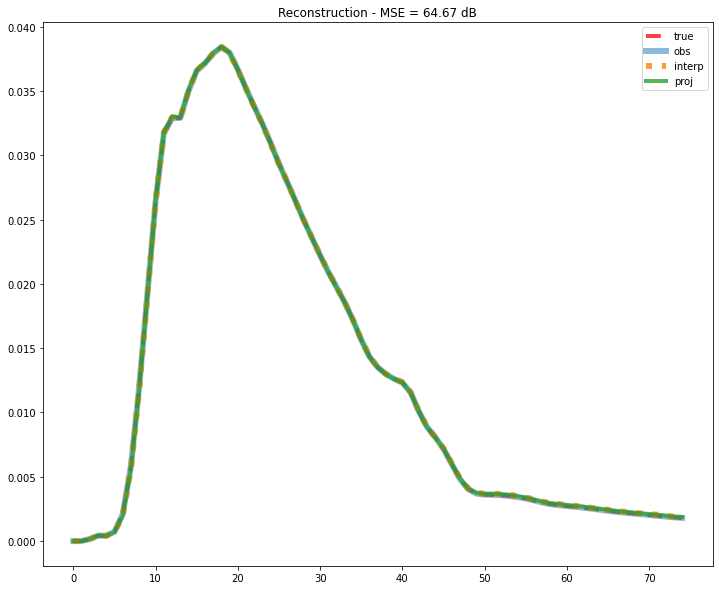

In [7]:
# Plots (optimization landscape, reconstructions) 

t = np.linspace(-1, 2, 128)
l1, l2 = np.meshgrid(t, t)
l1 = l1.flatten()
l2 = l2.flatten()
l3 = 1-l1-l2
Lambda = np.vstack((l1, l2, l3)).T
XRec = IAE.get_barycenter(Lambda)
errors = np.linalg.norm(XRec[np.newaxis, :, :] - Y[:, np.newaxis, :], axis=2)
errors = np.reshape(errors, (len(XTest), len(t), len(t)), order='F')

for i in range(10):
    
    z1, z2 = res_FI["Lambda"][i, :2]
    z12, z22 = res_BSP["Lambda"][i, :2]
    plt.figure(figsize=[12,10])
    plt.imshow(-20*np.log10(errors[i, :, :]), 
               extent=[np.min(t), np.max(t), np.max(t), np.min(t)]); plt.colorbar()
    plt.scatter(z2, z1, s=500, c='red', marker='.')
    plt.scatter(z22, z12, s=500, c='blue', marker='x')
    plt.title('Optimisation landscape - Cost as a function of the barycentric weights')
    plt.xlabel('lambda1')
    plt.ylabel('lambda2')
    plt.show()

    plt.figure(figsize=[12,10])
    plt.plot(XTest[i:i+1,:].squeeze(), 'r--', lw=4, alpha=0.75, label='true')
    plt.plot(Y[i:i+1,:].squeeze(), lw=6, alpha=0.5, label='obs')
    plt.plot(res_FI["XRec"][i:i+1,:].squeeze(), ':', lw=6, alpha=0.8, label='interp')
    plt.plot(res_BSP["XRec"][i:i+1,:].squeeze(),lw=4,alpha=0.8, label='proj')
    
    plt.title('Reconstruction - MSE = %.2f dB' % (-20*np.log10(np.linalg.norm(res_BSP["XRec"][i,:]-XTest[i,:]))))
    plt.legend()


Median: 67.50 - 1st quartile: 64.64 - 3rd quartile: 70.28


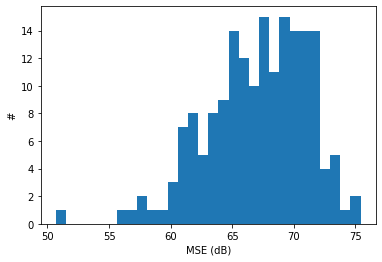

In [9]:
mses = -20*np.log10(np.linalg.norm(res_BSP["XRec"]-XTest, axis=1))
plt.xlabel('MSE (dB)')
plt.ylabel('#')
plt.hist(mses, bins=30);
print("Median: %.2f - 1st quartile: %.2f - 3rd quartile: %.2f" 
      % (np.median(mses), np.quantile(mses, 0.25), np.quantile(mses, 0.75)))